In [157]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import shapely as sa
from geopandas import GeoDataFrame
from shapely.geometry import Point

## 1. Loading data

### Loading and cleaning mean_price csv data

In [158]:
mean_price_ward = pd.read_csv('mean_price_ward.csv') #HPSSA dataset 38
#（https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/meanpricepaidbywardhpssadataset38）

print(mean_price_ward.describe(percentiles=[.05,0.95]))
print(mean_price_ward.info(verbose=True))

mean_price_ward

           Jun_2020      Jun_2022
count  6.360000e+02  6.370000e+02
mean   6.415244e+05  6.969343e+05
std    4.627200e+05  4.693080e+05
min    2.426460e+05  2.761770e+05
5%     3.229735e+05  3.536896e+05
50%    5.151560e+05  5.621800e+05
95%    1.373852e+06  1.476521e+06
max    5.416185e+06  4.521627e+06
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Local_authority_code  640 non-null    object 
 1   Local_authority_name  640 non-null    object 
 2   Ward_code             640 non-null    object 
 3   Ward_name             640 non-null    object 
 4   Jun_2020              636 non-null    float64
 5   Jun_2022              637 non-null    float64
dtypes: float64(2), object(4)
memory usage: 30.1+ KB
None


,Local_authority_code,Local_authority_name,Ward_code,Ward_name,Jun_2020,Jun_2022
0,E09000001,City of London,E05009288,Aldersgate,866090.0,807136.0
1,E09000001,City of London,E05009292,Bishopsgate,NaN,NaN
2,E09000001,City of London,E05009302,Cripplegate,1033318.0,1078667.0
3,E09000001,City of London,E05009304,Farringdon Within,NaN,755000.0
4,E09000001,City of London,E05009305,Farringdon Without,1263332.0,808929.0
...,...,...,...,...,...,...
635,E09000033,Westminster,E05000645,Tachbrook,795884.0,948557.0
636,E09000033,Westminster,E05000648,Westbourne,660118.0,727332.0
637,E09000033,Westminster,E05000649,West End,5416185.0,3983456.0
638,E09000033,Westminster,E05000647,Warwick,1107911.0,1137939.0


In [131]:
# Using function isna to check null value
a = mean_price_ward[mean_price_ward.Jun_2020.isna()]
b = mean_price_ward[mean_price_ward.Jun_2022.isna()]

print(a)
print(b)

  Local_authority_code Local_authority_name  Ward_code          Ward_name  \
1            E09000001       City of London  E05009292        Bishopsgate   
3            E09000001       City of London  E05009304  Farringdon Within   
5            E09000001       City of London  E05009308          Portsoken   
6            E09000001       City of London  E05009309         Queenhithe   

   Jun_2020  Jun_2022  
1       NaN       NaN  
3       NaN  755000.0  
5       NaN       NaN  
6       NaN       NaN  
  Local_authority_code Local_authority_name  Ward_code    Ward_name  Jun_2020  \
1            E09000001       City of London  E05009292  Bishopsgate       NaN   
5            E09000001       City of London  E05009308    Portsoken       NaN   
6            E09000001       City of London  E05009309   Queenhithe       NaN   

   Jun_2022  
1       NaN  
5       NaN  
6       NaN  


In [132]:
# Dealing with null value

mean_price_ward.groupby('Ward_name')

#Fill the null with the previous value (I think use the mean value of each LA will be better, but i am exploring)
mean_price_ward=mean_price_ward.fillna(method='pad')
mean_price_ward

,Local_authority_code,Local_authority_name,Ward_code,Ward_name,Jun_2020,Jun_2022
0,E09000001,City of London,E05009288,Aldersgate,866090.0,807136.0
1,E09000001,City of London,E05009292,Bishopsgate,866090.0,807136.0
2,E09000001,City of London,E05009302,Cripplegate,1033318.0,1078667.0
3,E09000001,City of London,E05009304,Farringdon Within,1033318.0,755000.0
4,E09000001,City of London,E05009305,Farringdon Without,1263332.0,808929.0
...,...,...,...,...,...,...
635,E09000033,Westminster,E05000645,Tachbrook,795884.0,948557.0
636,E09000033,Westminster,E05000648,Westbourne,660118.0,727332.0
637,E09000033,Westminster,E05000649,West End,5416185.0,3983456.0
638,E09000033,Westminster,E05000647,Warwick,1107911.0,1137939.0


In [133]:
# Save the new csc that has been cleaned
mean_price_ward.to_csv('mean_price_ward_cleaned.csv')

### Loading Elizabeth line shapefile (stations and track)

   OBJECTID   STATION_NA  SIZE_ SE_ANNO_CA                       geometry
0         1  Forest Gate  Small       None  POINT (540409.113 185311.628)
1         2   Manor Park  Small       None  POINT (541906.079 185683.241)
2         3       Ilford  Small       None  POINT (543515.859 186487.354)
3         4  Seven Kings  Small       None  POINT (545384.047 187089.399)
4         5    Goodmayes  Small       None  POINT (546470.589 187325.404)


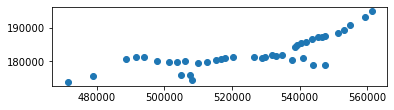

In [134]:
# Loading stations shapefile
tpath = 'Landmark_Data/CRL_Stations.shp'
stations = gpd.GeoDataFrame.from_file(tpath,encoding = 'gb18030')
stations.head()    
stations.plot()


print(stations.head())

   OBJECTID     ROUTEDESC    BRANCHDESC DIRECTDESC  \
0         1  Network Rail  Western Spur  Eastbound   
1         2  Network Rail  Western Spur  Eastbound   
2         3  Network Rail  Western Spur  Eastbound   
3         4  Network Rail  Western Spur  Eastbound   
4         5  Network Rail  Western Spur  Eastbound   

                                            geometry  
0  LINESTRING (521936.314 182273.252, 521935.366 ...  
1  LINESTRING (521959.564 182241.351, 521958.663 ...  
2  LINESTRING (521970.633 182264.311, 521969.731 ...  
3  LINESTRING (521961.418 182303.518, 521960.645 ...  
4  LINESTRING (521953.921 182240.761, 521952.973 ...  


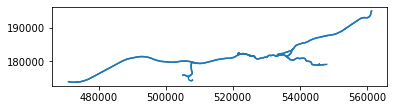

In [135]:
tpath = 'Landmark_Data/CRL_Track.shp'
track = gpd.GeoDataFrame.from_file(tpath,encoding = 'gb18030')
track.head()    
track.plot()



print(track.head())

### Loading London_ward shapefile 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        649 non-null    object  
 1   GSS_CODE    649 non-null    object  
 2   HECTARES    649 non-null    float64 
 3   NONLD_AREA  649 non-null    float64 
 4   LB_GSS_CD   649 non-null    object  
 5   BOROUGH     649 non-null    object  
 6   POLY_ID     649 non-null    int64   
 7   geometry    649 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 40.7+ KB
None


,NAME,Ward_code,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((517829.600 165447.100, 517837.100 16..."
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((518107.500 167303.400, 518114.300 16..."
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((520480.000 166909.800, 520490.700 16..."
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((522071.000 168144.900, 522063.900 16..."
...,...,...,...,...,...,...,...,...
644,Aldgate,E05000002,11.227,0.0,E09000001,City of London,51182,"POLYGON ((533326.100 181359.400, 533336.900 18..."
645,Broad Street,E05000008,8.188,0.0,E09000001,City of London,50669,"POLYGON ((532703.800 181263.500, 532707.800 18..."
646,Coleman Street,E05000012,15.404,0.0,E09000001,City of London,122520,"POLYGON ((532880.500 181723.400, 532884.200 18..."
647,Portsoken,E05000021,6.209,0.0,E09000001,City of London,122516,"POLYGON ((533814.300 180968.900, 533757.200 18..."


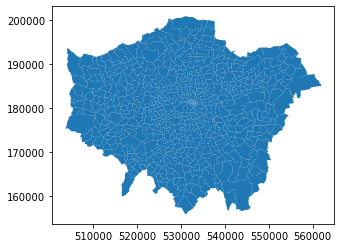

In [167]:
tpath = 'statistical-gis-boundaries-london/ESRI/London_Ward.shp'
WARD = gpd.GeoDataFrame.from_file(tpath,encoding = 'gb18030')
WARD.head()   
WARD.plot()
print(WARD.info(verbose=True))
WARD.rename(columns={"GSS_CODE":"Ward_code"},inplace=True)

WARD

### Reprojection

In [160]:
# Detecting crs
print(WARD.crs)
print(stations.crs)
print(track.crs)

PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
epsg:27700
epsg:27700


In [161]:
# Reprojection
WARD = WARD.to_crs('epsg:27700')
stations = stations.to_crs('epsg:27700')
track = track.to_crs('epsg:27700')

print(WARD.crs)
print(stations.crs)
print(track.crs)

epsg:27700
epsg:27700
epsg:27700


## 2. Manipulating data 

In [169]:
# Combining price and ward
mean_price_merge=pd.merge(WARD, mean_price_ward, on='Ward_code',how='left')

There are still some null values, which are due to missing official data of mean_price csv, thus filling in the null value again:

In [170]:
# Dealing with null value
mean_price_merge['Jun_2020'] =mean_price_merge['Jun_2020'].fillna(method='pad')
mean_price_merge['Jun_2022'] =mean_price_merge['Jun_2022'].fillna(method='pad')
mean_price_merge

,NAME,Ward_code,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,Local_authority_code,Local_authority_name,Ward_name,Jun_2020,Jun_2022
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16...",E09000021,Kingston upon Thames,Chessington South,401678.0,414114.0
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((517829.600 165447.100, 517837.100 16...",E09000021,Kingston upon Thames,Tolworth and Hook Rise,445920.0,472984.0
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((518107.500 167303.400, 518114.300 16...",E09000021,Kingston upon Thames,Berrylands,537843.0,526481.0
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((520480.000 166909.800, 520490.700 16...",E09000021,Kingston upon Thames,Alexandra,540261.0,603113.0
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((522071.000 168144.900, 522063.900 16...",E09000021,Kingston upon Thames,Beverley,516176.0,694858.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,Aldgate,E05000002,11.227,0.0,E09000001,City of London,51182,"POLYGON ((533326.100 181359.400, 533336.900 18...",NaN,NaN,NaN,306462.0,341330.0
645,Broad Street,E05000008,8.188,0.0,E09000001,City of London,50669,"POLYGON ((532703.800 181263.500, 532707.800 18...",NaN,NaN,NaN,306462.0,341330.0
646,Coleman Street,E05000012,15.404,0.0,E09000001,City of London,122520,"POLYGON ((532880.500 181723.400, 532884.200 18...",NaN,NaN,NaN,306462.0,341330.0
647,Portsoken,E05000021,6.209,0.0,E09000001,City of London,122516,"POLYGON ((533814.300 180968.900, 533757.200 18...",NaN,NaN,NaN,306462.0,341330.0


<AxesSubplot:>

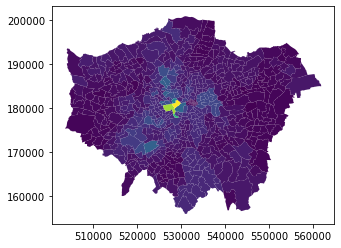

In [174]:
mean_price_merge.plot(column='Jun_2020')

In [172]:
# mean_price_merge=pd.merge(WARD, mean_price_ward, on='Ward_code',how='left')
#pd.merge(stations, mean_price_merge, on="geometry",how='inner')

,OBJECTID,STATION_NA,SIZE_,SE_ANNO_CA,geometry,NAME,Ward_code,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,Local_authority_code,Local_authority_name,Ward_name,Jun_2020,Jun_2022


In [141]:
#mean_price_merge_point = stations.join(mean_price_merge, lsuffix="geometry", rsuffix="geometry")
#mean_price_merge_point

,OBJECTID,STATION_NA,SIZE_,SE_ANNO_CA,geometrygeometry,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometrygeometry,Local_authority_code,Local_authority_name,Ward_code,Ward_name,Jun_2020,Jun_2022
0,1,Forest Gate,Small,None,POINT (540409.113 185311.628),Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16...",E09000001,City of London,E05009288,Aldersgate,866090.0,807136.0
1,2,Manor Park,Small,None,POINT (541906.079 185683.241),Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((517829.600 165447.100, 517837.100 16...",E09000001,City of London,E05009292,Bishopsgate,866090.0,807136.0
2,3,Ilford,Small,None,POINT (543515.859 186487.354),Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((518107.500 167303.400, 518114.300 16...",E09000001,City of London,E05009302,Cripplegate,1033318.0,1078667.0
3,4,Seven Kings,Small,None,POINT (545384.047 187089.399),Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((520480.000 166909.800, 520490.700 16...",E09000001,City of London,E05009304,Farringdon Within,1033318.0,755000.0
4,5,Goodmayes,Small,None,POINT (546470.589 187325.404),Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((522071.000 168144.900, 522063.900 16...",E09000001,City of London,E05009305,Farringdon Without,1263332.0,808929.0
5,6,Chadwell Heath,Small,None,POINT (547602.706 187606.678),Coombe Hill,E05000406,442.170,0.0,E09000021,Kingston upon Thames,117159,"POLYGON ((522007.600 169297.300, 521931.800 16...",E09000001,City of London,E05009308,Portsoken,1263332.0,808929.0
6,7,Romford,Large,None,POINT (551323.362 188458.678),Chessington North and Hook,E05000404,192.980,0.0,E09000021,Kingston upon Thames,50530,"POLYGON ((517175.300 164077.300, 517165.400 16...",E09000001,City of London,E05009309,Queenhithe,1263332.0,808929.0
7,8,Gidea Park,Small,None,POINT (552957.607 189327.989),Surbiton Hill,E05000413,166.482,0.0,E09000021,Kingston upon Thames,50457,"POLYGON ((517469.300 166878.500, 517960.500 16...",E09000001,City of London,E05009310,Tower,2145030.0,625000.0
8,9,Custom House,Large,None,POINT (540872.750 180939.059),Old Malden,E05000410,180.016,0.0,E09000021,Kingston upon Thames,50455,"POLYGON ((522231.100 166015.000, 522198.000 16...",E09000002,Barking and Dagenham,E05000026,Abbey,276810.0,276177.0
9,10,Maryland,Small,None,POINT (539193.946 184915.750),St. Mark's,E05000412,137.578,0.0,E09000021,Kingston upon Thames,50450,"POLYGON ((517460.600 167802.900, 517490.400 16...",E09000002,Barking and Dagenham,E05000027,Alibon,303912.0,338842.0


In [177]:
a = mean_price_merge_point
# a = a.drop([])
a.shape
mean_price_merge_point_change = pd.concat([a.iloc[:,:4],a.iloc[:,5:]], axis = 1)
print(mean_price_merge_point_change.shape)
mean_price_merge_point_change

(41, 18)


,OBJECTID,STATION_NA,SIZE_,SE_ANNO_CA,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometrygeometry,Local_authority_code,Local_authority_name,Ward_code,Ward_name,Jun_2020,Jun_2022
0,1,Forest Gate,Small,None,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16...",E09000001,City of London,E05009288,Aldersgate,866090.0,807136.0
1,2,Manor Park,Small,None,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((517829.600 165447.100, 517837.100 16...",E09000001,City of London,E05009292,Bishopsgate,866090.0,807136.0
2,3,Ilford,Small,None,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((518107.500 167303.400, 518114.300 16...",E09000001,City of London,E05009302,Cripplegate,1033318.0,1078667.0
3,4,Seven Kings,Small,None,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((520480.000 166909.800, 520490.700 16...",E09000001,City of London,E05009304,Farringdon Within,1033318.0,755000.0
4,5,Goodmayes,Small,None,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((522071.000 168144.900, 522063.900 16...",E09000001,City of London,E05009305,Farringdon Without,1263332.0,808929.0
5,6,Chadwell Heath,Small,None,Coombe Hill,E05000406,442.170,0.0,E09000021,Kingston upon Thames,117159,"POLYGON ((522007.600 169297.300, 521931.800 16...",E09000001,City of London,E05009308,Portsoken,1263332.0,808929.0
6,7,Romford,Large,None,Chessington North and Hook,E05000404,192.980,0.0,E09000021,Kingston upon Thames,50530,"POLYGON ((517175.300 164077.300, 517165.400 16...",E09000001,City of London,E05009309,Queenhithe,1263332.0,808929.0
7,8,Gidea Park,Small,None,Surbiton Hill,E05000413,166.482,0.0,E09000021,Kingston upon Thames,50457,"POLYGON ((517469.300 166878.500, 517960.500 16...",E09000001,City of London,E05009310,Tower,2145030.0,625000.0
8,9,Custom House,Large,None,Old Malden,E05000410,180.016,0.0,E09000021,Kingston upon Thames,50455,"POLYGON ((522231.100 166015.000, 522198.000 16...",E09000002,Barking and Dagenham,E05000026,Abbey,276810.0,276177.0
9,10,Maryland,Small,None,St. Mark's,E05000412,137.578,0.0,E09000021,Kingston upon Thames,50450,"POLYGON ((517460.600 167802.900, 517490.400 16...",E09000002,Barking and Dagenham,E05000027,Alibon,303912.0,338842.0


In [178]:
# mean_price_merge_point_change = GeoDataFrame(mean_price_merge_point_change, crs="EPSG:27700", geometry='geometrygeometry')

<AxesSubplot:>

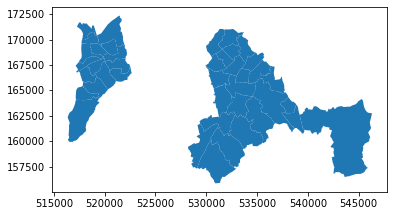

In [179]:
# mean_price_merge_point_change.plot()

### Plotting

(155000.0, 202000.0)

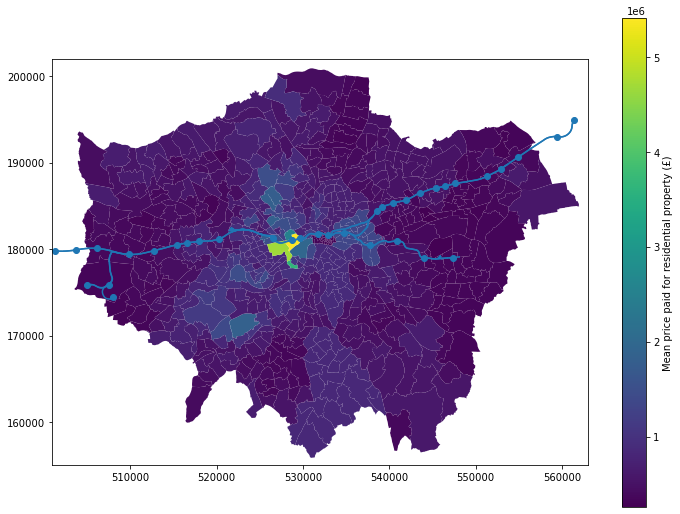

In [180]:
fig, ax = plt.subplots(1,1, figsize=(12,9))


mean_price_merge.plot(ax=ax,figsize=(12,8), marker='*', markersize=0.25,  
         column='Jun_2020', cmap='viridis', legend=True, legend_kwds={'label':'Mean price paid for residential property (£)'})
stations.plot(ax=ax)
track.plot(ax=ax)

# Set the x and y limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)

(155000.0, 202000.0)

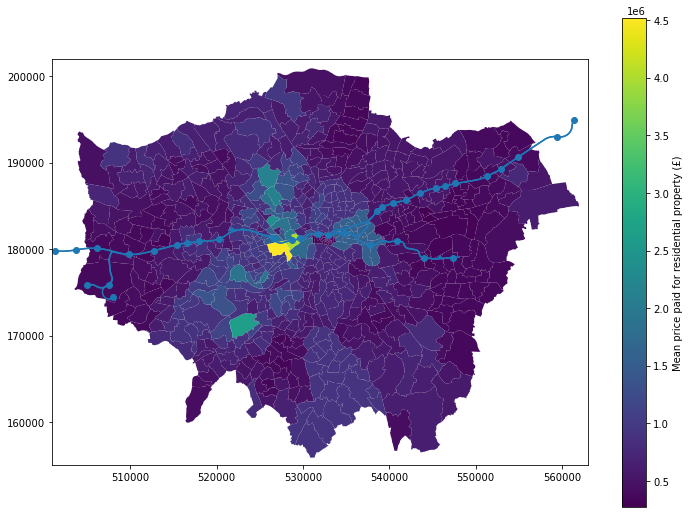

In [181]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

mean_price_merge.plot(ax=ax,figsize=(12,8), marker='*', markersize=0.25,  
         column='Jun_2022', cmap='viridis', legend=True, legend_kwds={'label':'Mean price paid for residential property (£)'})
stations.plot(ax=ax)
track.plot(ax=ax)

# Set the x and y limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)